## Q-learning (3 points)

This notebook will guide you through implementation of vanilla Q-learning algorithm.

You need to implement QLearningAgent (follow instructions for each method) and use it on a number of tests below.

In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Starting virtual X frame buffer: Xvfb../xvfb: line 24: start-stop-daemon: command not found
.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from collections import defaultdict
import random
import math
import numpy as np


class QLearningAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        """
        Q-Learning Agent
        based on https://inst.eecs.berkeley.edu/~cs188/sp19/projects.html
        Instance variables you have access to
          - self.epsilon (exploration prob)
          - self.alpha (learning rate)
          - self.discount (discount rate aka gamma)

        Functions you should use
          - self.get_legal_actions(state) {state, hashable -> list of actions, each is hashable}
            which returns legal actions for a state
          - self.get_qvalue(state,action)
            which returns Q(state,action)
          - self.set_qvalue(state,action,value)
            which sets Q(state,action) := value
        !!!Important!!!
        Note: please avoid using self._qValues directly. 
            There's a special self.get_qvalue/set_qvalue for that.
        """

        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        """ Sets the Qvalue for [state,action] to the given value """
        self._qvalues[state][action] = value

    #---------------------START OF YOUR CODE---------------------#

    def get_value(self, state):
        """
        Compute your agent's estimate of V(s) using current q-values
        V(s) = max_over_action Q(state,action) over possible actions.
        Note: please take into account that q-values can be negative.
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        return max([self.get_qvalue(state, action) for action in possible_actions])


    def update(self, state, action, reward, next_state):
        """
        You should do your Q-Value update here:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """

        # agent parameters
        gamma = self.discount
        learning_rate = self.alpha

        reference_qvalue = reward + gamma * self.get_value(next_state)
        updated_qvalue = learning_rate * reference_qvalue + (1 - learning_rate) * self.get_qvalue(state, action)

        self.set_qvalue(state, action, updated_qvalue)


    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values). 
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        return max(possible_actions, key=lambda action: self.get_qvalue(state, action))


    def get_action(self, state):
        """
        Compute the action to take in the current state, including exploration.  
        With probability self.epsilon, we should take a random action.
            otherwise - the best policy action (self.get_best_action).

        Note: To pick randomly from a list, use random.choice(list). 
              To pick True or False with a given probablity, generate uniform number in [0, 1]
              and compare it with your probability
        """

        # Pick Action
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        if random.random() < self.epsilon:
            return random.choice(possible_actions)
        else:
            return self.get_best_action(state)

In [3]:
class EVSarsaAgent(QLearningAgent):
    """ 
    An agent that changes some of q-learning functions to implement Expected Value SARSA. 
    Note: this demo assumes that your implementation of QLearningAgent.update uses get_value(next_state).
    If it doesn't, please add
        def update(self, state, action, reward, next_state):
            and implement it for Expected Value SARSA's V(s')
    """

    def get_value(self, state):
        """ 
        Returns Vpi for current state under epsilon-greedy policy:
          V_{pi}(s) = sum _{over a_i} {pi(a_i | s) * Q(s, a_i)}

        Hint: all other methods from QLearningAgent are still accessible.
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        q_values = [self.get_qvalue(state, action) for action in possible_actions]
        max_q = np.max(q_values)

        ## Представь ситуацию, когда эпсилон = 0.2, действий 4, из них 2 жадных
        ## Тогда вероятность каждого из двух случайных действий - 0.05, а двух жадных - 0.45 
        ## Жадное действие может случиться и рандомно, поэтому для них + prob_of_random_action
        prob_of_random_action = self.epsilon / len(possible_actions)
        prob_of_greedy_action = (1 - self.epsilon) / np.sum(q_values == max_q) + prob_of_random_action

        return np.sum([q * prob_of_greedy_action 
                       if q == max_q 
                       else q * prob_of_random_action 
                       for q in q_values])

    # def get_action(self, state):

    #     # Pick Action
    #     possible_actions = self.get_legal_actions(state)

    #     # If there are no legal actions, return None
    #     if len(possible_actions) == 0:
    #         return None

    #     return self.get_best_action(state)

In [4]:
class SoftmaxEVSarsaAgent(QLearningAgent):
    def __init__(self, tau, *args, **kwargs):
        """
        Add one more param - Tau.
        Tau - at large Tau all probabilities of actions will be similar, 
            - at small Tau even a small difference in Q(s,ai) makes quite a difference to prob of selecting action ai.
        """
        super(self.__class__, self).__init__(*args, **kwargs)
        self.tau = tau


    def get_prob_softmax(self, q_values=None, state=None, possible_actions=None):
        """
        Calc softmax for q_values of selected actions for selected state
        """
        if not q_values:
            q_values = [self.get_qvalue(state, action) for action in possible_actions]

        q_values_softmax = np.exp(np.array(q_values) / self.tau)
        q_values_softmax /= np.sum(q_values_softmax)

        return q_values_softmax


    def get_value(self, state):
        """ 
        This is what makes SoftmaxEVSarsaAgent special
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        q_values = [self.get_qvalue(state, action) for action in possible_actions]

        return np.sum([q * prob for q, prob in zip(q_values, self.get_prob_softmax(q_values=q_values))])


    def get_action(self, state):
        """
        Difference - if we make non-greedy action, it will be chosen based on softmax probabilities 
        """
        # Pick Action
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        # return self.get_best_action(state)

        return np.random.choice(possible_actions, p = self.get_prob_softmax(state=state, possible_actions=possible_actions))

        # if random.random() < self.epsilon:
        #     return np.random.choice(possible_actions, p = self.get_prob_softmax(state=state, possible_actions=possible_actions))
        # else:
        #     return self.get_best_action(state)

### Try it on taxi

Here we use the qlearning agent on taxi env from openai gym.
You will need to insert a few agent functions here.

In [5]:
import gym
env = gym.make("Taxi-v3")

n_actions = env.action_space.n

In [6]:
def play_and_train(env, agent, t_max=10**4):
    """
    This function should 
    - run a full game, actions given by agent's e-greedy policy
    - train agent using agent.update(...) whenever it is possible
    - return total reward
    """
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        # get agent to pick action given state s.
        a = agent.get_action(s)

        next_s, r, done, _ = env.step(a)

        # train (update) agent for state s
        agent.update(s, a, r, next_s)

        s = next_s
        total_reward += r
        if done:
            break

    return total_reward

EVSARSA_SM mean reward = 7.16
EVSARSA mean reward = 7.4
QLEARNING mean reward = 6.89


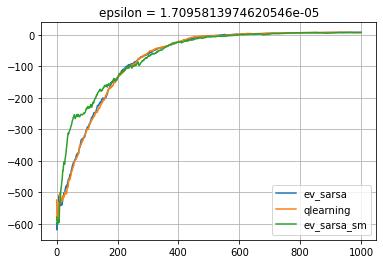

In [23]:
from IPython.display import clear_output
import pandas as pd

def moving_average(x, span=100):
    return pd.DataFrame({'x': np.asarray(x)}).x.ewm(span=span).mean().values

rewards_sarsa_sm, rewards_sarsa, rewards_ql = [], [], []

agent_sarsa_sm = SoftmaxEVSarsaAgent(alpha=0.25, epsilon=0.4, discount=0.99,
                          get_legal_actions=lambda s: range(n_actions),
                          tau=1*1e-1)

agent_sarsa = EVSarsaAgent(alpha=0.25, epsilon=0.4, discount=0.99,
                           get_legal_actions=lambda s: range(n_actions))

agent_ql = QLearningAgent(alpha=0.25, epsilon=0.4, discount=0.99,
                          get_legal_actions=lambda s: range(n_actions))

for i in range(1001):
    rewards_sarsa_sm.append(play_and_train(env, agent_sarsa_sm))
    rewards_sarsa.append(play_and_train(env, agent_sarsa))
    rewards_ql.append(play_and_train(env, agent_ql))

    # agent_sarsa_sm.tau *= 0.999
    agent_sarsa_sm.epsilon *= 0.99
    agent_sarsa.epsilon *= 0.99
    agent_ql.epsilon *= 0.99

    if i % 100 == 0:
        plt.title("epsilon = %s" % agent_ql.epsilon)
        plt.plot(moving_average(rewards_sarsa), label='ev_sarsa')
        plt.plot(moving_average(rewards_ql), label='qlearning')
        plt.plot(moving_average(rewards_sarsa_sm), label='ev_sarsa_sm')
        plt.grid()
        plt.legend()
        # plt.ylim(-500, 0)

        clear_output(True)
        print('EVSARSA_SM mean reward =', np.mean(rewards_sarsa_sm[-100:]))
        print('EVSARSA mean reward =', np.mean(rewards_sarsa[-100:]))
        print('QLEARNING mean reward =', np.mean(rewards_ql[-100:]))
        plt.show()

# Binarized state spaces

Use agent to train efficiently on `CartPole-v0`. This environment has a continuous set of possible states, so you will have to group them into bins somehow.

The simplest way is to use `round(x, n_digits)` (or `np.round`) to round a real number to a given amount of digits. The tricky part is to get the `n_digits` right for each state to train effectively.

Note that you don't need to convert state to integers, but to __tuples__ of any kind of values.

In [79]:
def make_env():
    return gym.make('CartPole-v0').env  # .env unwraps the TimeLimit wrapper

env = make_env()
n_actions = env.action_space.n

print("first state: %s" % (env.reset()))
# plt.imshow(env.render('rgb_array'))

first state: [-0.02669743 -0.03011741 -0.04893304  0.00292886]


### Play a few games

We need to estimate observation distributions. To do so, we'll play a few games and record all states.

In [25]:
def visualize_cartpole_observation_distribution(seen_observations):
    seen_observations = np.array(seen_observations)
    
    # The meaning of the observations is documented in
    # https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py

    f, axarr = plt.subplots(2, 2, figsize=(16, 9), sharey=True)
    for i, title in enumerate(['Cart Position', 'Cart Velocity', 'Pole Angle', 'Pole Velocity At Tip']):
        ax = axarr[i // 2, i % 2]
        ax.hist(seen_observations[:, i], bins=20)
        ax.set_title(title)
        xmin, xmax = ax.get_xlim()
        ax.set_xlim(min(xmin, -xmax), max(-xmin, xmax))
        ax.grid()
    f.tight_layout()

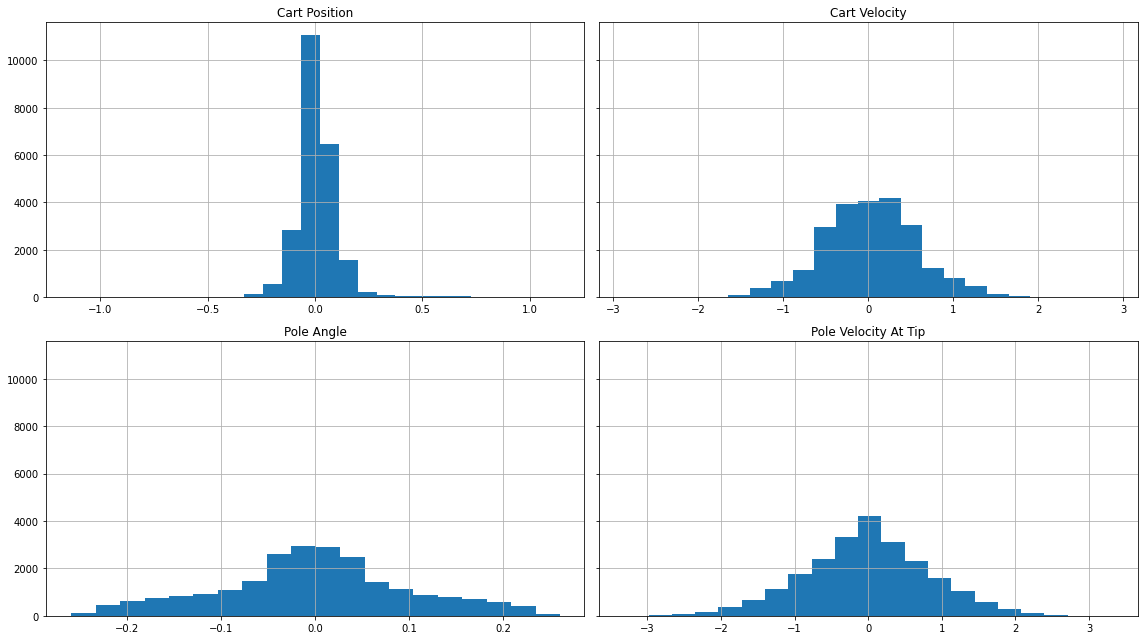

In [28]:
seen_observations = []
for _ in range(1000):
    seen_observations.append(env.reset())
    done = False
    while not done:
        s, r, done, _ = env.step(env.action_space.sample())
        seen_observations.append(s)

visualize_cartpole_observation_distribution(seen_observations)

## Binarize environment

In [80]:
from gym.core import ObservationWrapper


class Binarizer(ObservationWrapper):
    def observation(self, state):
        # Hint: you can do that with round(x, n_digits).
        # You may pick a different n_digits for each dimension.
        # state = <YOUR CODE: round state to some amount digits>
        
        # state = tuple([round(s_i, 2) for s_i in state])

        state = tuple([
            round(state[0], 1),
            round(state[1], 1),
            round(state[2], 2),
            round(state[3], 1),
            ])

        # state = tuple([
        #     int(10 *state[0]), 
        #     int(5  *state[1]),
        #     int(20 *state[2]),
        #     int(5  *state[3]),
        #     ])

        return state

In [81]:
env = Binarizer(make_env())

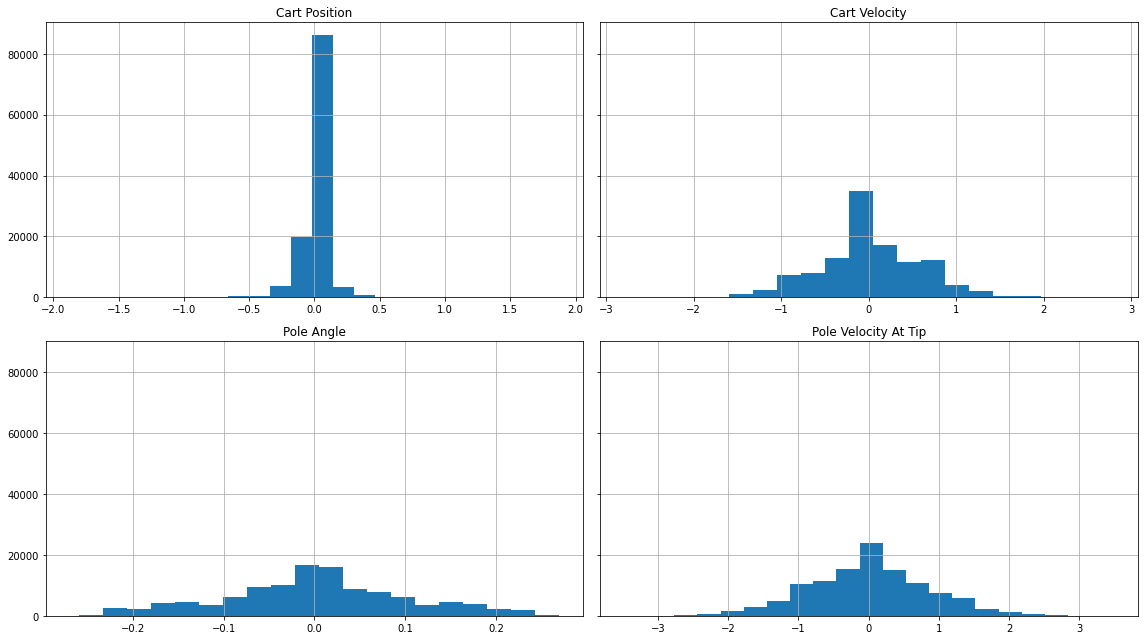

In [45]:
seen_observations = []
for _ in range(5000):
    seen_observations.append(env.reset())
    done = False
    while not done:
        s, r, done, _ = env.step(env.action_space.sample())
        seen_observations.append(s)
        if done:
            break

visualize_cartpole_observation_distribution(seen_observations)

## Learn binarized policy

Now let's train a policy that uses binarized state space.

__Tips:__

* Note that increasing the number of digits for one dimension of the observations increases your state space by a factor of $10$.
* If your binarization is too fine-grained, your agent will take much longer than 10000 steps to converge. You can either increase the number of iterations and reduce epsilon decay or change binarization. In practice we found that this kind of mistake is rather frequent.
* If your binarization is too coarse, your agent may fail to find the optimal policy. In practice we found that on this particular environment this kind of mistake is rare.
* **Start with a coarse binarization** and make it more fine-grained if that seems necessary.
* Having $10^3$–$10^4$ distinct states is recommended (`len(agent._qvalues)`), but not required.
* If things don't work without annealing $\varepsilon$, consider adding that, but make sure that it doesn't go to zero too quickly.

A reasonable agent should attain an average reward of at least 50.

EVSARSA_SM mean reward = 1230.01
EVSARSA mean reward = 140.83
QLEARNING mean reward = 211.22


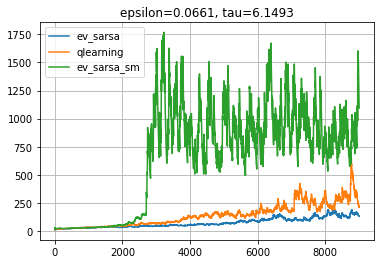

In [70]:
from IPython.display import clear_output
import pandas as pd

def moving_average(x, span=100):
    return pd.DataFrame({'x': np.asarray(x)}).x.ewm(span=span).mean().values

rewards_sarsa_sm, rewards_sarsa, rewards_ql = [], [], []

agent_sarsa_sm = SoftmaxEVSarsaAgent(alpha=0.25, epsilon=0.4, discount=0.999,
                          get_legal_actions=lambda s: range(n_actions),
                          tau=2.5*1e0)

# starting with tau=2.5 and slowly increasing *= 1.0001 gives the best results

agent_sarsa = EVSarsaAgent(alpha=0.25, epsilon=0.4, discount=0.99,
                           get_legal_actions=lambda s: range(n_actions))

agent_ql = QLearningAgent(alpha=0.25, epsilon=0.4, discount=0.99,
                          get_legal_actions=lambda s: range(n_actions))

for i in range(9000+1):
    rewards_sarsa_sm.append(play_and_train(env, agent_sarsa_sm))
    rewards_sarsa.append(play_and_train(env, agent_sarsa))
    rewards_ql.append(play_and_train(env, agent_ql))

    agent_sarsa_sm.tau *= 1.0001
    # agent_sarsa_sm.tau *= 0.9999
    agent_sarsa_sm.epsilon *= 0.9998
    agent_sarsa.epsilon *= 0.9998
    agent_ql.epsilon *= 0.9998

    if i % 300 == 0:
        plt.title(f"epsilon={round(agent_ql.epsilon, 4)}, tau={round(agent_sarsa_sm.tau, 4)}")
        plt.plot(moving_average(rewards_sarsa), label='ev_sarsa')
        plt.plot(moving_average(rewards_ql), label='qlearning')
        plt.plot(moving_average(rewards_sarsa_sm), label='ev_sarsa_sm')
        plt.grid()
        plt.legend()
        # plt.ylim(-500, 0)

        clear_output(True)
        print('EVSARSA_SM mean reward =', np.mean(rewards_sarsa_sm[-100:]))
        print('EVSARSA mean reward =', np.mean(rewards_sarsa[-100:]))
        print('QLEARNING mean reward =', np.mean(rewards_ql[-100:]))
        plt.show()

In [71]:
print('Your agent_sarsa_sm has learned {} Q-values.'.format(len(agent_sarsa_sm._qvalues)))
print('Your agent_sarsa has learned {} Q-values.'.format(len(agent_sarsa._qvalues)))
print('Your agent_ql has learned {} Q-values.'.format(len(agent_ql._qvalues)))

Your agent_sarsa_sm has learned 49484 Q-values.
Your agent_sarsa has learned 17211 Q-values.
Your agent_ql has learned 18340 Q-values.


In [7]:
def play(env, agent, t_max=10**4):
    """
    This function should 
    - run a full game, actions given by agent's e-greedy policy
    - train agent using agent.update(...) whenever it is possible
    - return total reward
    """
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        # get agent to pick action given state s.
        a = agent.get_action(s)

        next_s, r, done, _ = env.step(a)

        s = next_s
        total_reward += r
        if done:
            break

    return total_reward

In [77]:
for _ in range(10):
    tst_rewards = []
    for _ in range(100):
        tst_rewards.append(play(env, agent_sarsa_sm))
        # tst_rewards.append(play(env, agent_sarsa))
        # tst_rewards.append(play(env, agent_ql))

    print(np.mean(tst_rewards))

922.16
1075.22
951.74
878.07
1087.39
1029.62
1159.86
1116.21
749.39
1036.16


# With replays!

In [77]:
import random

class ReplayBuffer(object):
    def __init__(self, size):
        """
        Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = np.empty([0,5])
        self._maxsize = size

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        '''
        Make sure, _storage will not exceed _maxsize. 
        Make sure, FIFO rule is being followed: the oldest examples has to be removed earlier
        '''
        if len(self._storage) < self._maxsize:
            self._storage = np.append(self._storage, [[obs_t, action, reward, obs_tp1, done]], axis = 0)
        else:
            self._storage = np.append(self._storage[1:,], [[obs_t, action, reward, obs_tp1, done]], axis = 0)

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = np.random.choice(len(self._storage), batch_size)

        ## One liner wokrs too, but a bit slower
        # return tuple(map(tuple, self._storage[idxes, :].T))
    
        return (
            self._storage[idxes, 0],
            self._storage[idxes, 1],
            self._storage[idxes, 2],
            self._storage[idxes, 3],
            self._storage[idxes, 4],
        )

In [78]:
def play_and_train_with_replay(env, agent, replay=None,
                               t_max=10**4, replay_batch_size=32):
    """
    This function should 
    - run a full game, actions given by agent.get_action(s)
    - train agent using agent.update(...) whenever possible
    - return total reward
    :param replay: ReplayBuffer where agent can store and sample (s,a,r,s',done) tuples.
        If None, do not use experience replay
    """
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        # get agent to pick action given state s
        # a = <YOUR CODE>
        a = agent.get_action(s)

        next_s, r, done, _ = env.step(a)

        # update agent on current transition. Use agent.update
        # <YOUR CODE>
        agent.update(s, a, r, next_s)

        if replay is not None:
            # store current <s,a,r,s'> transition in buffer
            # <YOUR CODE>
            replay.add(s, a, r, next_s, done)

            # sample replay_batch_size random transitions from replay,
            # then update agent on each of them in a loop
            s_, a_, r_, next_s_, done_ = replay.sample(replay_batch_size)
            for i in range(replay_batch_size):
                # <YOUR CODE>
                # if done_[i] == 0:
                agent.update(s_[i], a_[i], r_[i], next_s_[i])

        s = next_s
        total_reward += r
        if done:
            break

    return total_reward

EVSARSA_SM mean reward = 1702.31
EVSARSA mean reward = 7437.16
QLEARNING mean reward = 3519.26


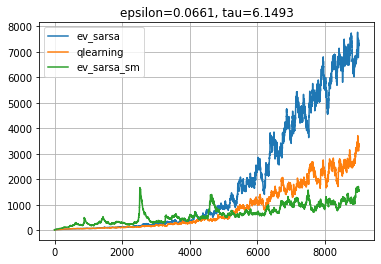

In [84]:
from IPython.display import clear_output
import pandas as pd

def moving_average(x, span=100):
    return pd.DataFrame({'x': np.asarray(x)}).x.ewm(span=span).mean().values

rewards_sarsa_sm, rewards_sarsa, rewards_ql = [], [], []

agent_sarsa_sm = SoftmaxEVSarsaAgent(alpha=0.25, epsilon=0.4, discount=0.999,
                          get_legal_actions=lambda s: range(n_actions),
                          tau=2.5*1e0)

# starting with tau=2.5 and slowly increasing *= 1.0001 gives the best results

agent_sarsa = EVSarsaAgent(alpha=0.25, epsilon=0.4, discount=0.99,
                           get_legal_actions=lambda s: range(n_actions))

agent_ql = QLearningAgent(alpha=0.25, epsilon=0.4, discount=0.99,
                          get_legal_actions=lambda s: range(n_actions))

replay = ReplayBuffer(1000)

for i in range(9000+1):
    rewards_sarsa_sm.append(play_and_train_with_replay(env, agent_sarsa_sm, replay))
    rewards_sarsa.append(play_and_train_with_replay(env, agent_sarsa, replay))
    rewards_ql.append(play_and_train_with_replay(env, agent_ql, replay))

    agent_sarsa_sm.tau *= 1.0001
    # agent_sarsa_sm.tau *= 0.9999
    agent_sarsa_sm.epsilon *= 0.9998
    agent_sarsa.epsilon *= 0.9998
    agent_ql.epsilon *= 0.9998

    if i % 300 == 0:
        plt.title(f"epsilon={agent_ql.epsilon:.4f}, tau={agent_sarsa_sm.tau:.4f}")
        plt.plot(moving_average(rewards_sarsa), label='ev_sarsa')
        plt.plot(moving_average(rewards_ql), label='qlearning')
        plt.plot(moving_average(rewards_sarsa_sm), label='ev_sarsa_sm')
        plt.grid()
        plt.legend()
        # plt.ylim(-500, 0)

        clear_output(True)
        print('EVSARSA_SM mean reward =', np.mean(rewards_sarsa_sm[-100:]))
        print('EVSARSA mean reward =', np.mean(rewards_sarsa[-100:]))
        print('QLEARNING mean reward =', np.mean(rewards_ql[-100:]))
        plt.show()

In [85]:
print('Your agent_sarsa_sm has learned {} Q-values.'.format(len(agent_sarsa_sm._qvalues)))
print('Your agent_sarsa has learned {} Q-values.'.format(len(agent_sarsa._qvalues)))
print('Your agent_ql has learned {} Q-values.'.format(len(agent_ql._qvalues)))

Your agent_sarsa_sm has learned 114987 Q-values.
Your agent_sarsa has learned 115309 Q-values.
Your agent_ql has learned 103863 Q-values.


In [87]:
for _ in range(10):
    tst_rewards = []
    for _ in range(100):
        # tst_rewards.append(play(env, agent_sarsa_sm))
        tst_rewards.append(play(env, agent_sarsa))
        # tst_rewards.append(play(env, agent_ql))

    print(np.mean(tst_rewards))

7809.61
7968.76
7503.91
7472.57
7947.28
6903.08
7907.37
8178.74
8451.82
7533.19


In [97]:
total_reward = 0.0
s = env.reset()

for t in range(10**4):
    a = agent_sarsa.get_action(s)
    s, r, done, _ = env.step(a)
    total_reward += r
    if done:
        break

    env.render('rgb_array')
    
print(total_reward)

10000.0
